In [2]:
# Get possible to import from parent
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
pparentdir = os.path.dirname(parentdir)
sys.path.insert(0,parentdir) 

from implicit.ResNetModel import ResNetModel
from implicit.Model import SequentialBlockModel
import time
import torch
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import scipy.sparse as sp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# ResNet20 error: 7.17% surprisingly low for this model
resume = 'saved_models/ResNet20model.th'
model = ResNetModel([3,3,3])

INFO: <function FlattenOpL.__init__.<locals>.<lambda> at 0x7f74a81120e0> is not a torch Module


In [9]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, m):
        super().__init__()
        self.module = m
        self.add_module("module", m)
        self.A = None; self.B = None; self.C = None; self.D = None; self.phi = None

    def forward(self, x):
        return self.module(x)

    def implicit_forward(self, x):
        if self.A is None:
            self.module.seqmodel.populate_C = True
            self.A, self.B, self.C, self.D, self.phi = self.module.seqmodel.getImplicitModel(x[0:1, :])
            self.A = sp.csr_matrix(self.A)

        out = SequentialBlockModel.implicit_forward(self.A, self.B, self.C, self.D, self.phi, x)
        out1 = torch.Tensor(out)
        out2 = self.forward(x)
        print("norm diff for the batch: {}".format(torch.norm(out2 - out1)))
        out2.copy_(out1)
        return out2

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='../data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])),
    batch_size=128, shuffle=False)

print("=> loading checkpoint '{}'".format(resume))
checkpoint = torch.load(resume)
model = ModelWrapper(model)
model.load_state_dict(checkpoint['state_dict'], strict=True)
print("=> loaded checkpoint")

Files already downloaded and verified
=> loading checkpoint 'saved_models/ResNet20model.th'
=> loaded checkpoint


In [10]:
# get A,B,C,D,phi
model.eval()
for xs, ys in val_loader:
    model.module.seqmodel.populate_C = True
    A,B,C,D,phi = model.module.seqmodel.getImplicitModel(xs[0:1, :])
    break

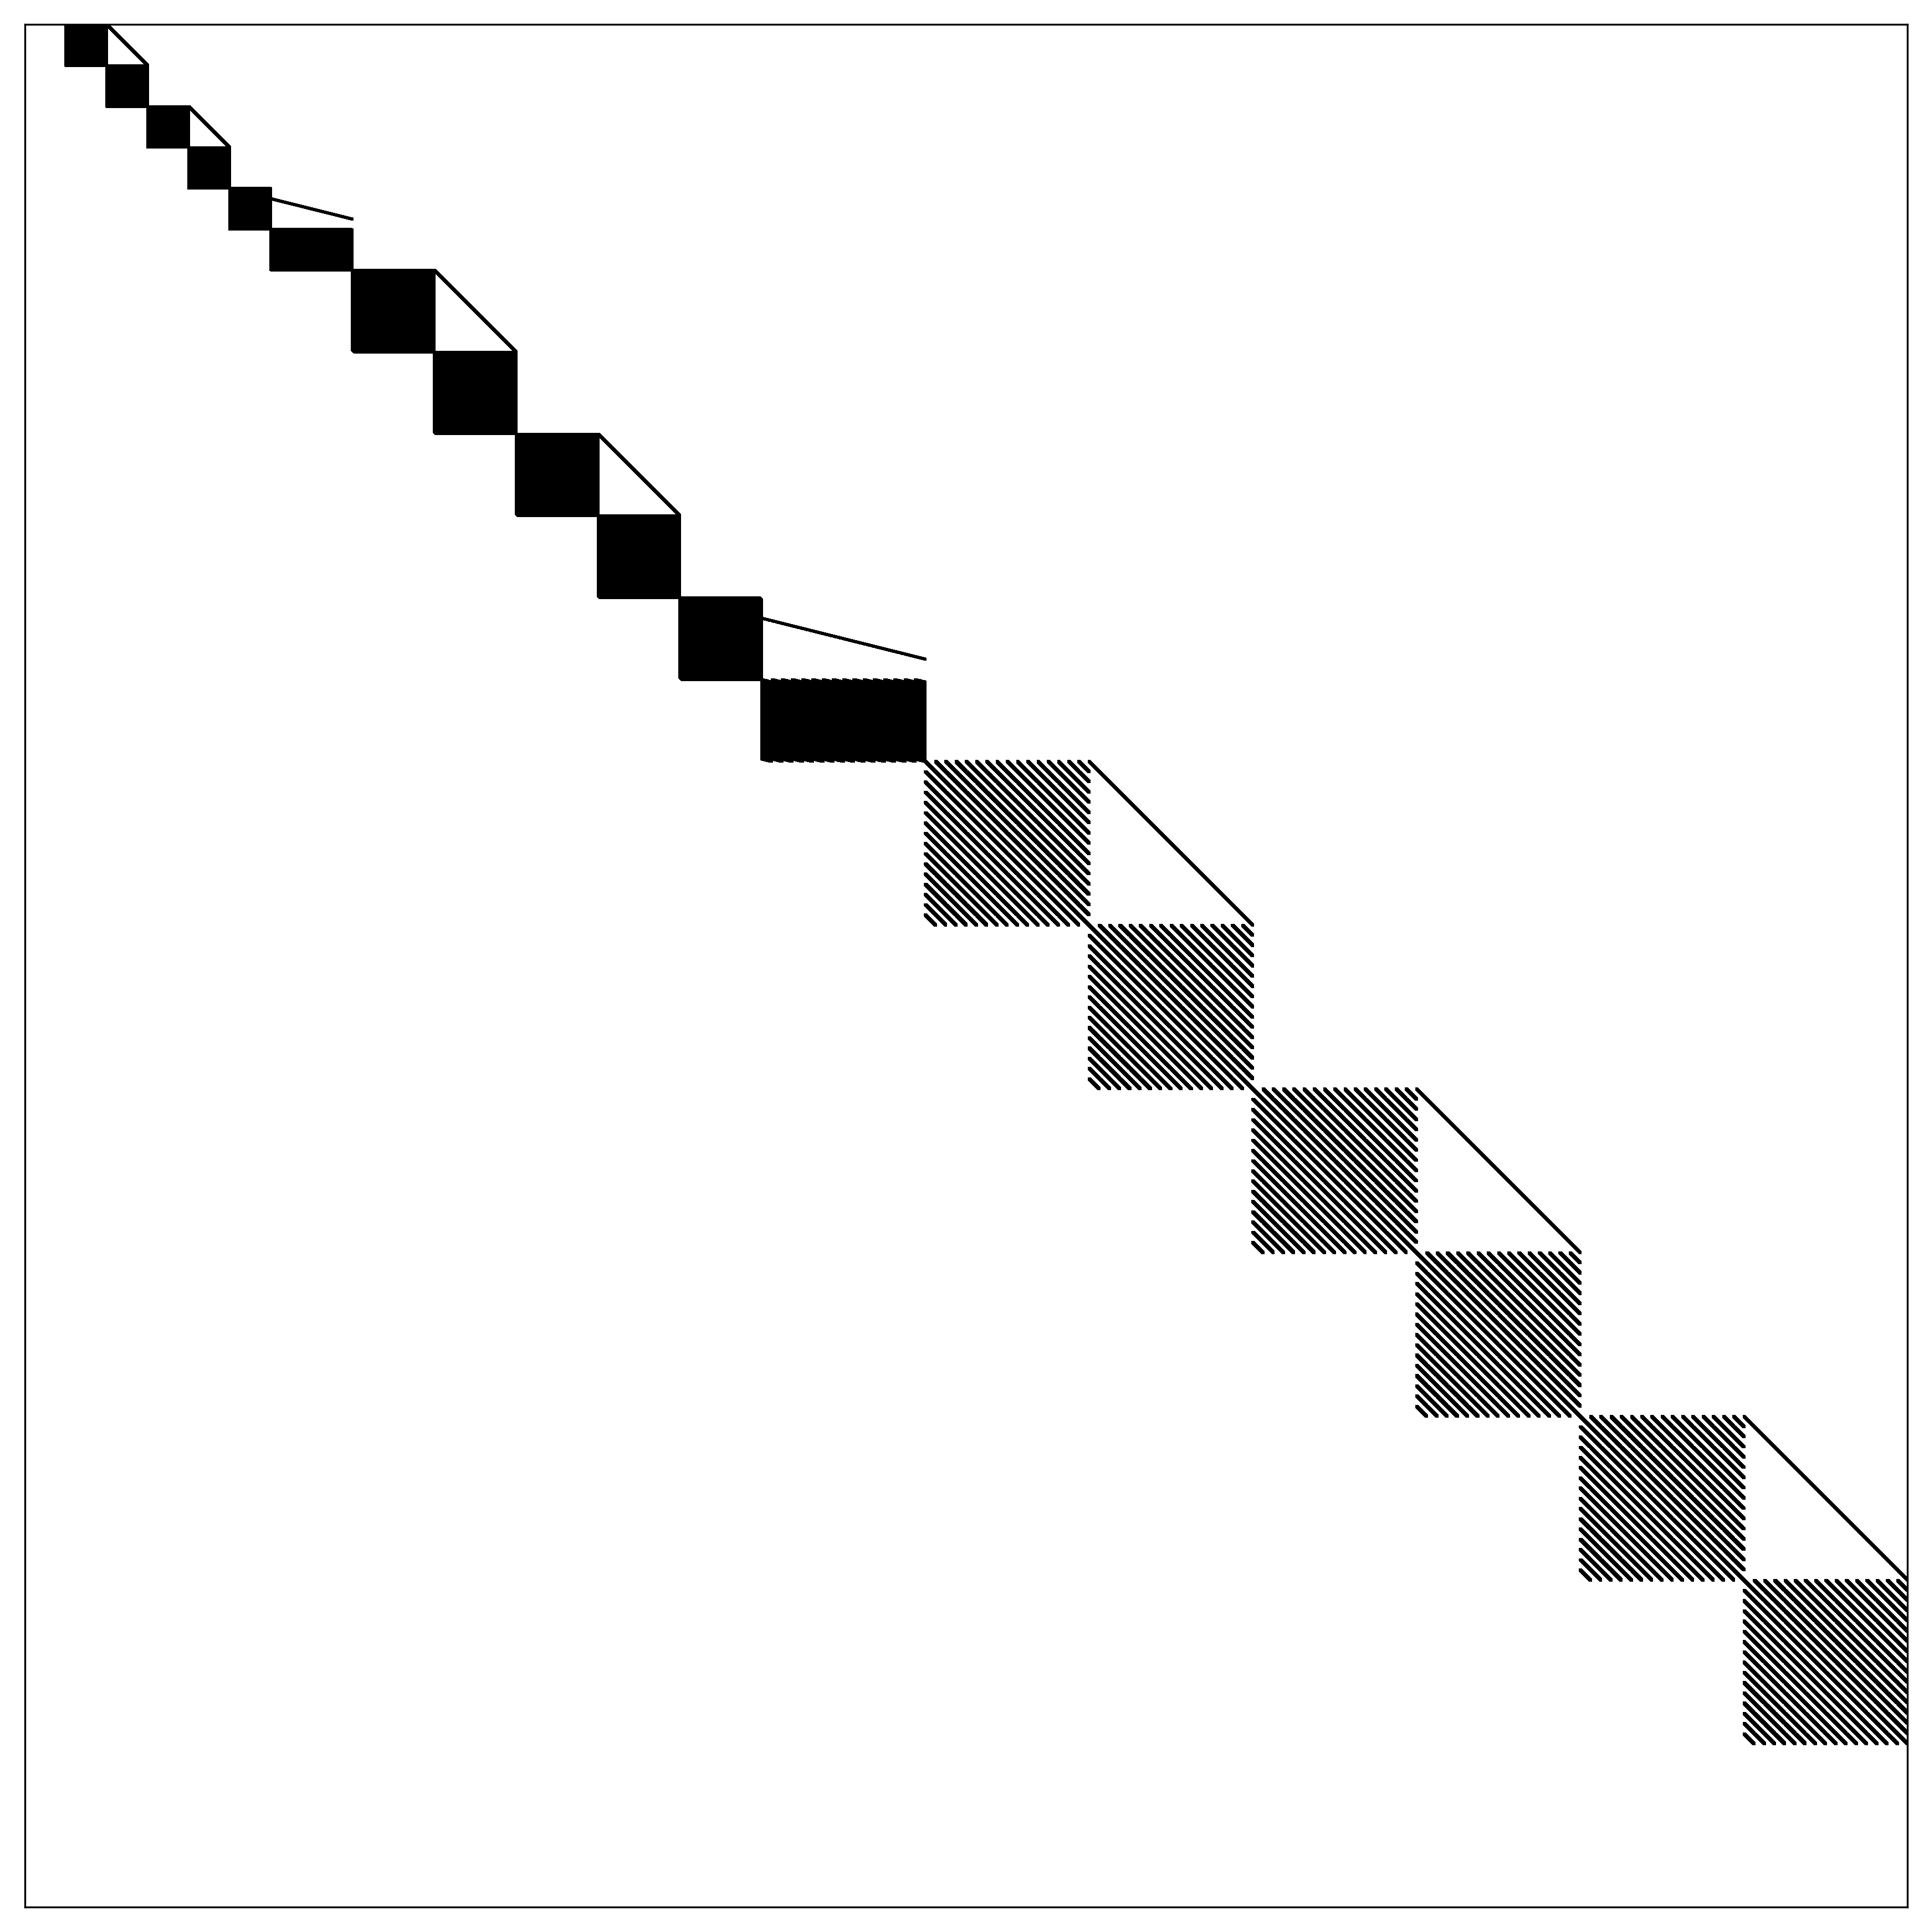

In [11]:
plt.figure(figsize=(15,15), dpi=300)
plt.spy(A, markersize=0.01, color='black')
plt.xticks([], [])
plt.yticks([], [])
plt.show()
#plt.savefig("res20.pdf")

In [12]:
M=sp.bmat([[C,D], [A,B]])

In [13]:
A.shape

(188416, 188416)

In [14]:
# get block A
A1,b1 = model.module.seqmodel.blocklist[6].Ab()
A2,b2 = model.module.seqmodel.blocklist[7].Ab()

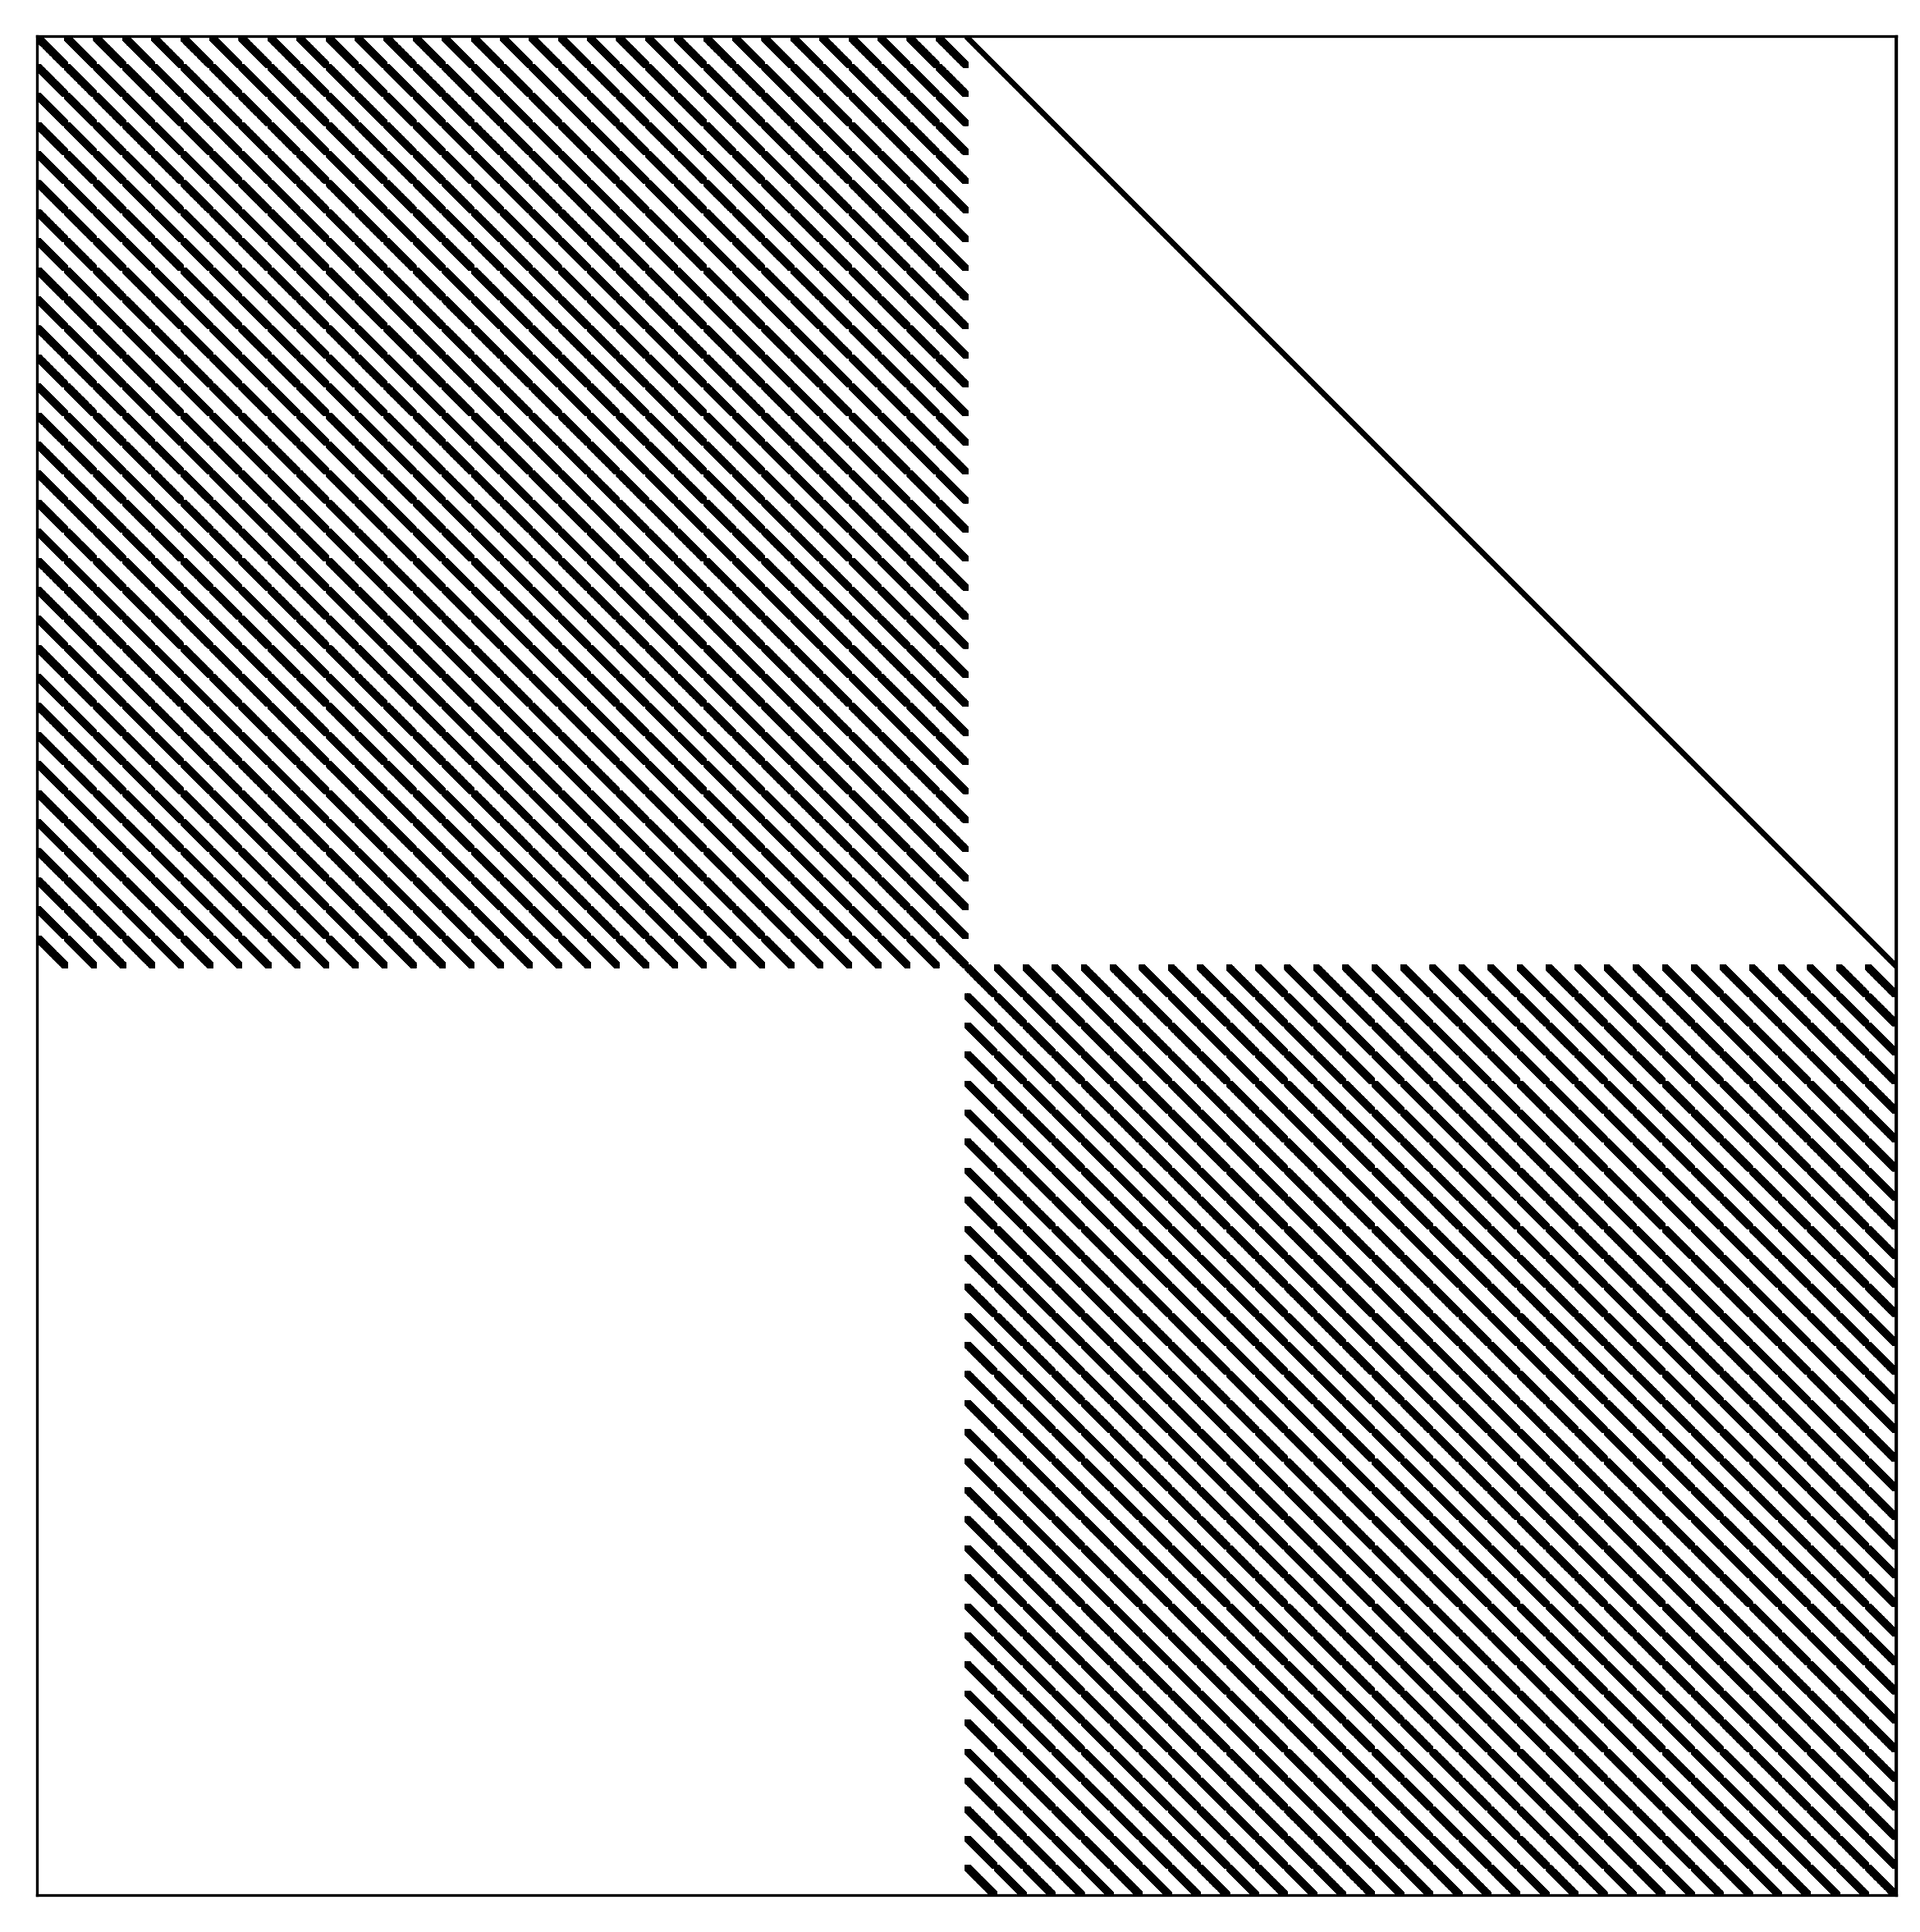

In [15]:
plt.figure(figsize=(10,10), dpi=300)
plt.spy(sp.bmat([[A1,b1]]), markersize=0.01, color='black')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [16]:
plt.show()

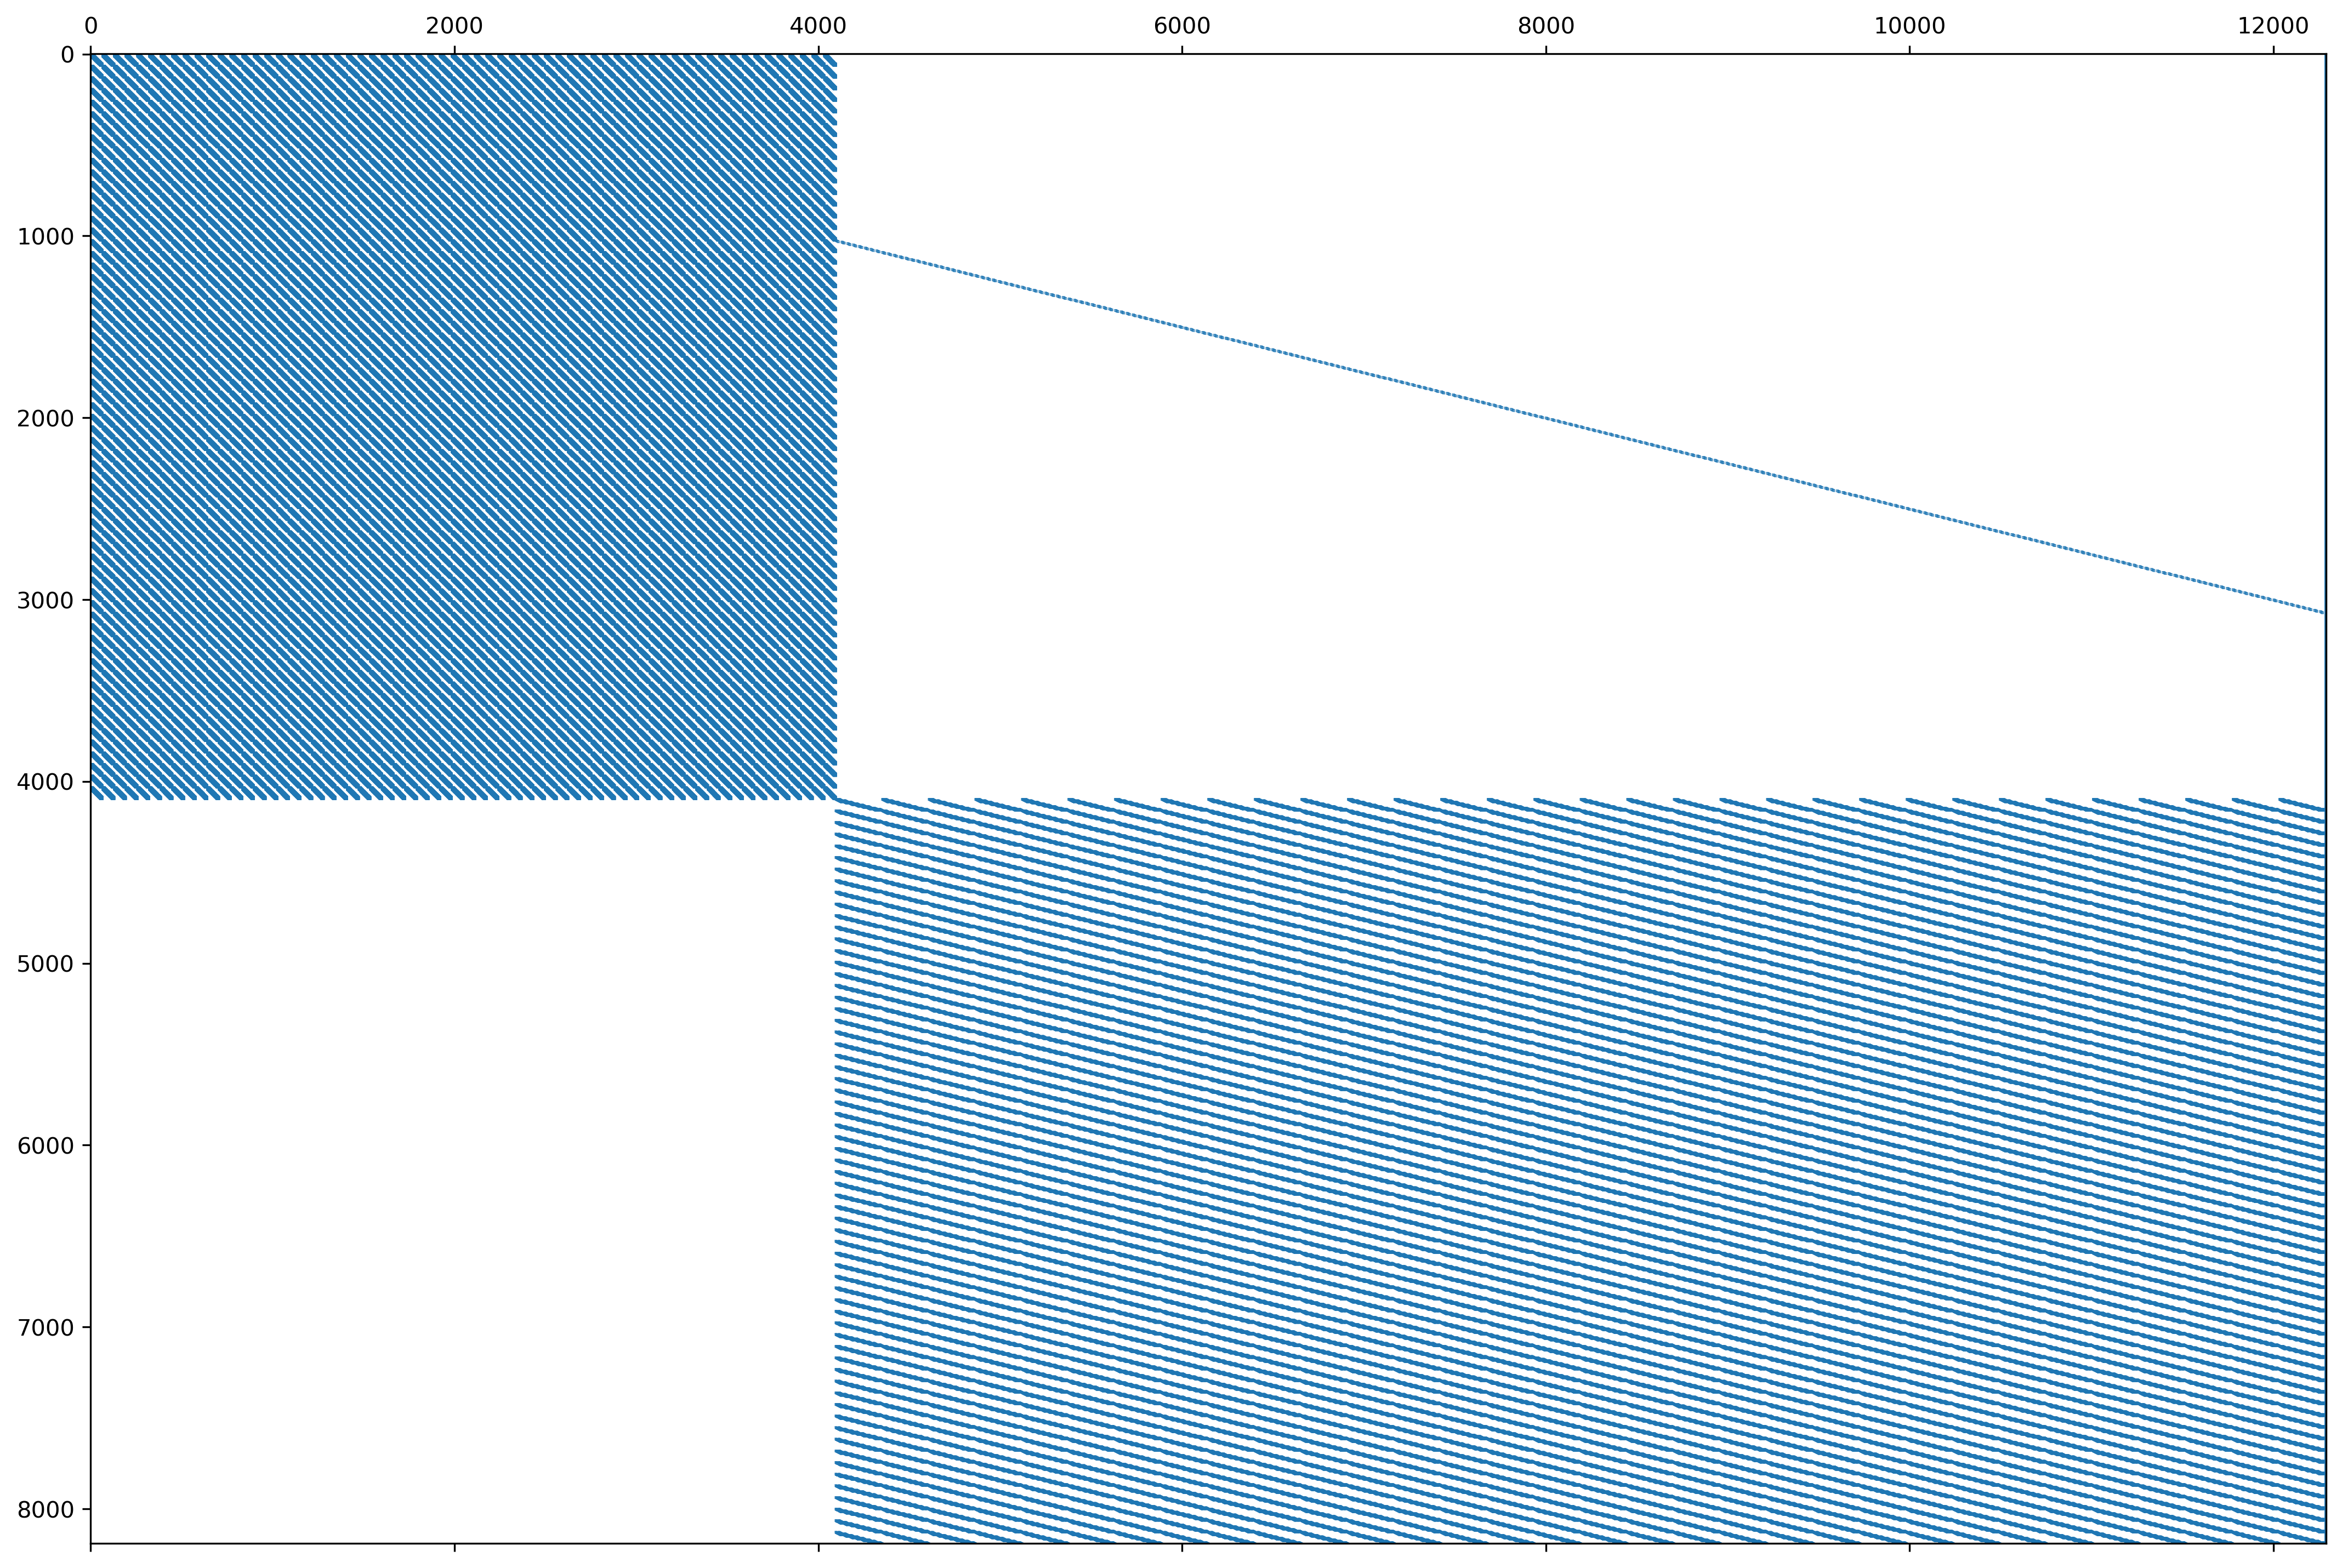

In [17]:
plt.figure(figsize=(18,12), dpi=300)
plt.spy(sp.bmat([[A2,b2]]), markersize=0.01)
plt.show()

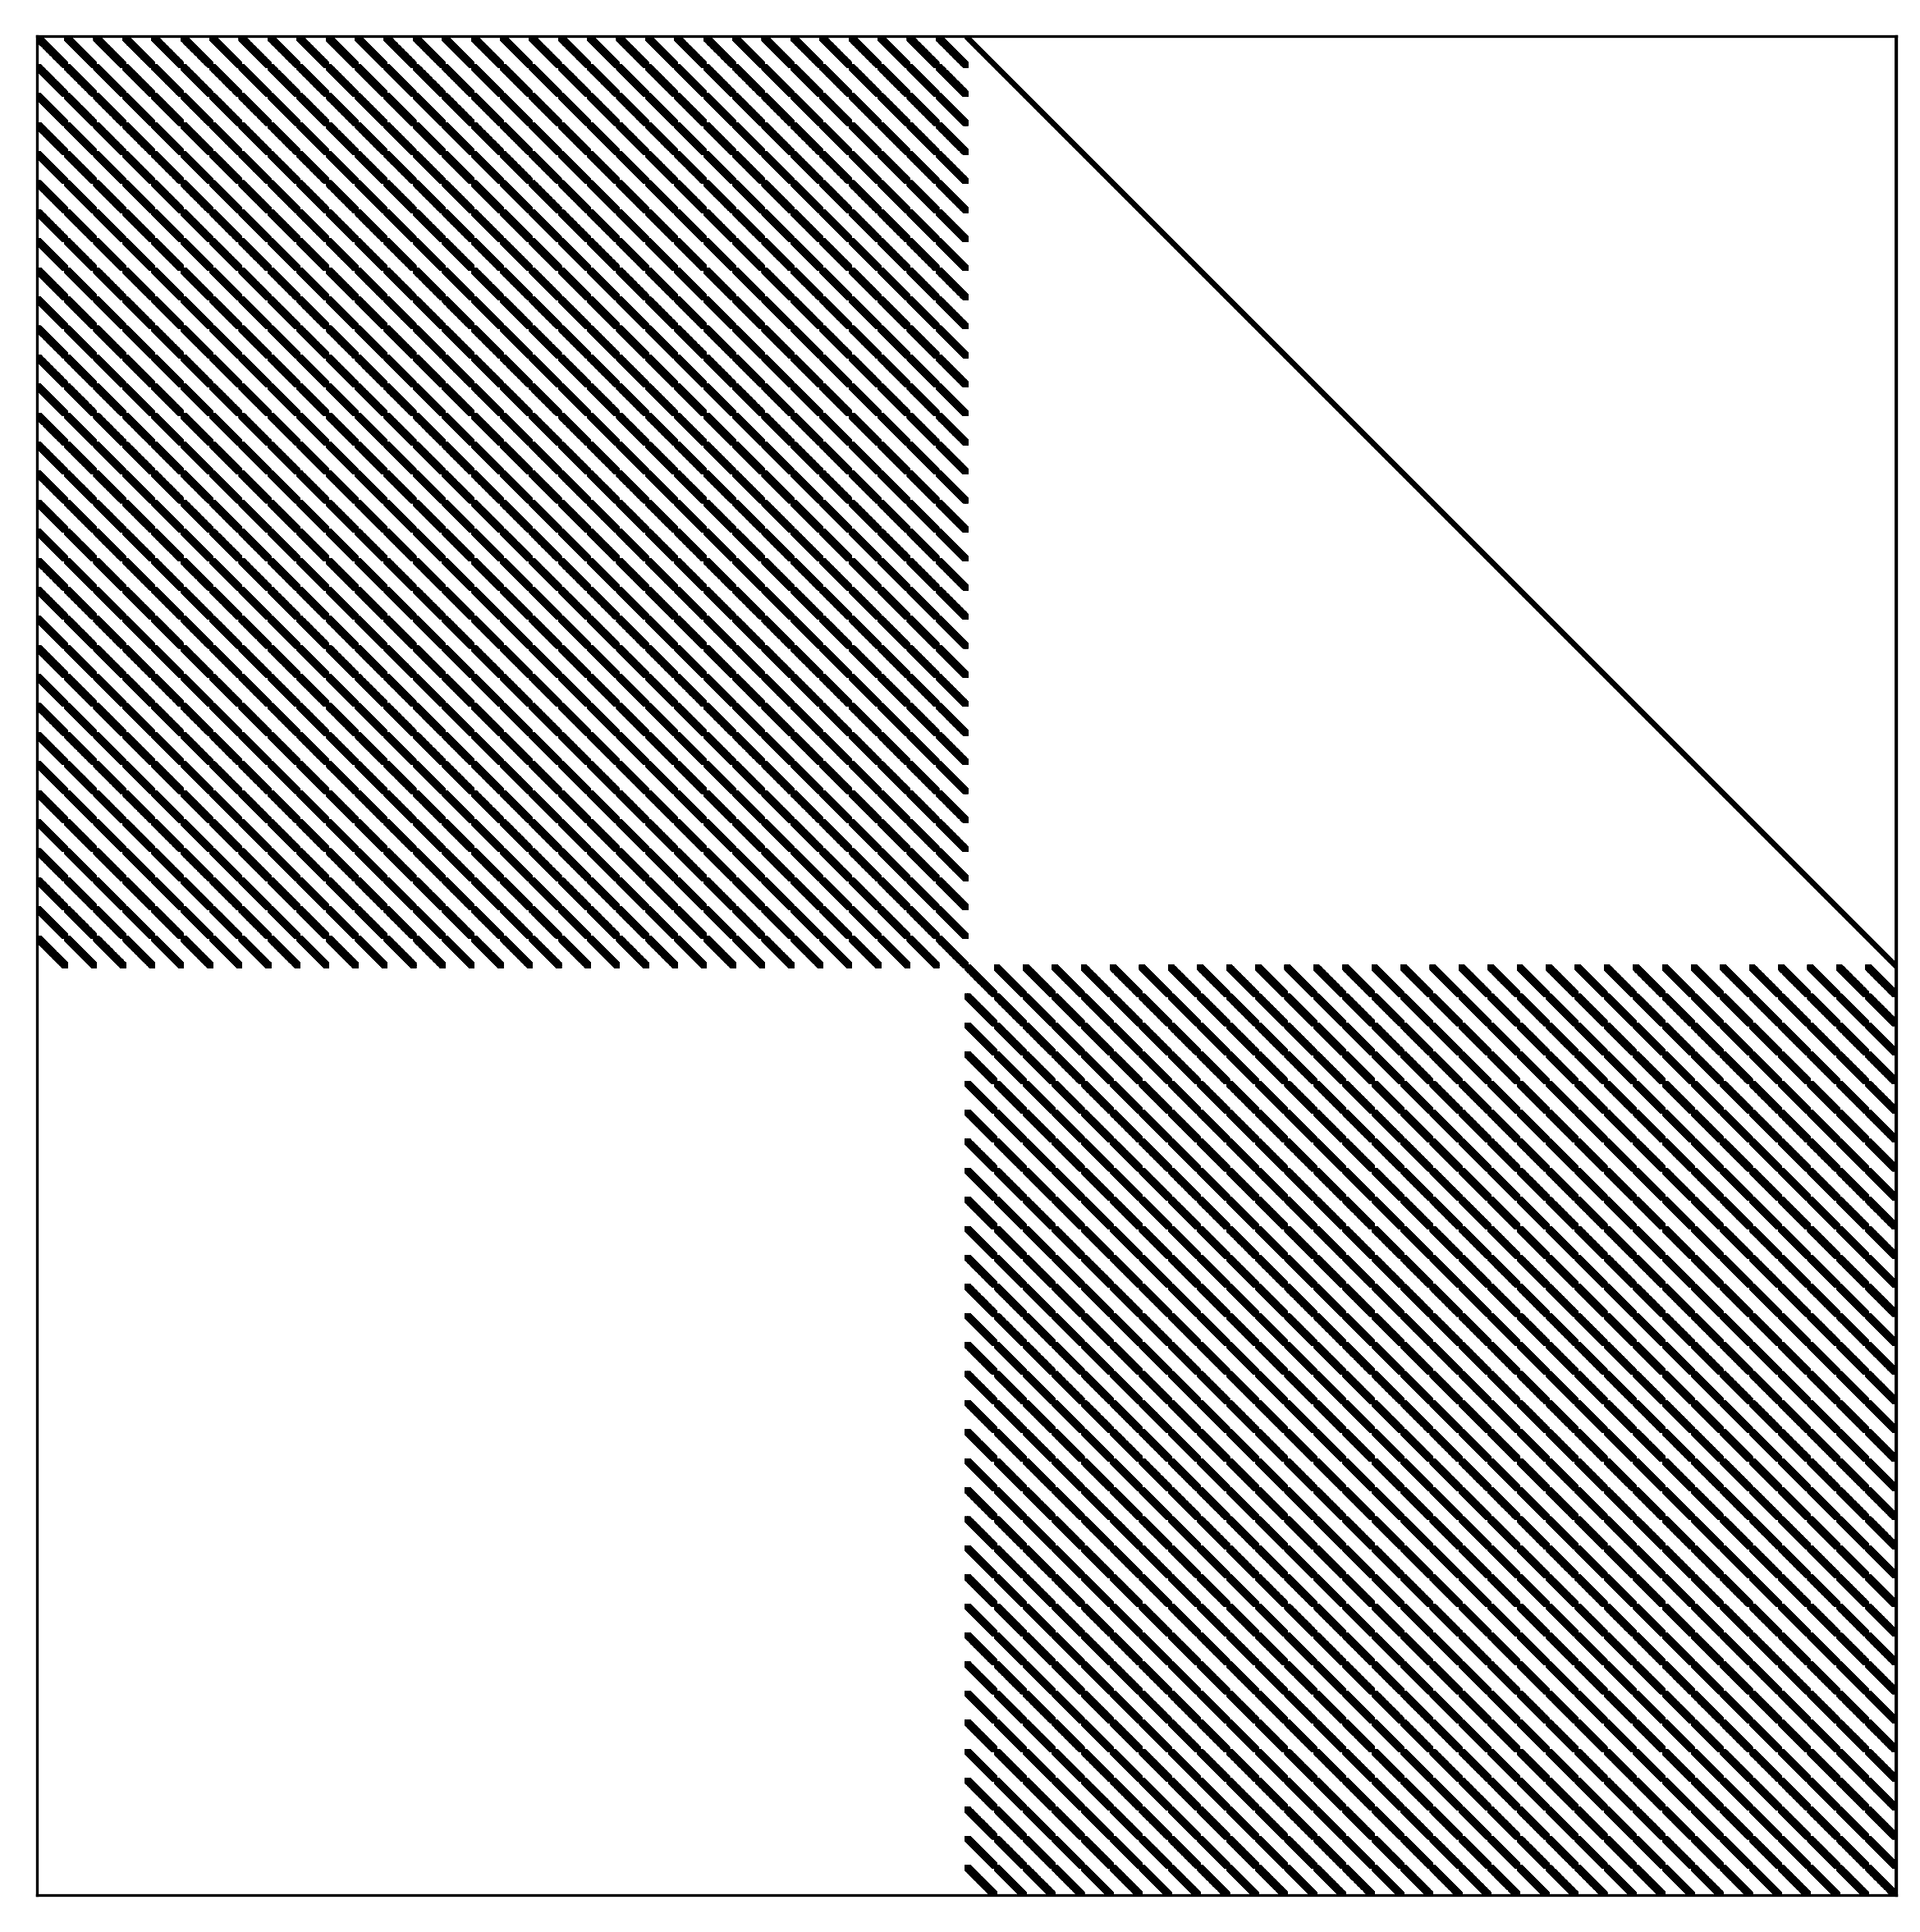

In [18]:
plt.figure(figsize=(10,10), dpi=300)
plt.spy(sp.bmat([[A1,b1]]), markersize=0.01, color='black')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [19]:
plt.show()

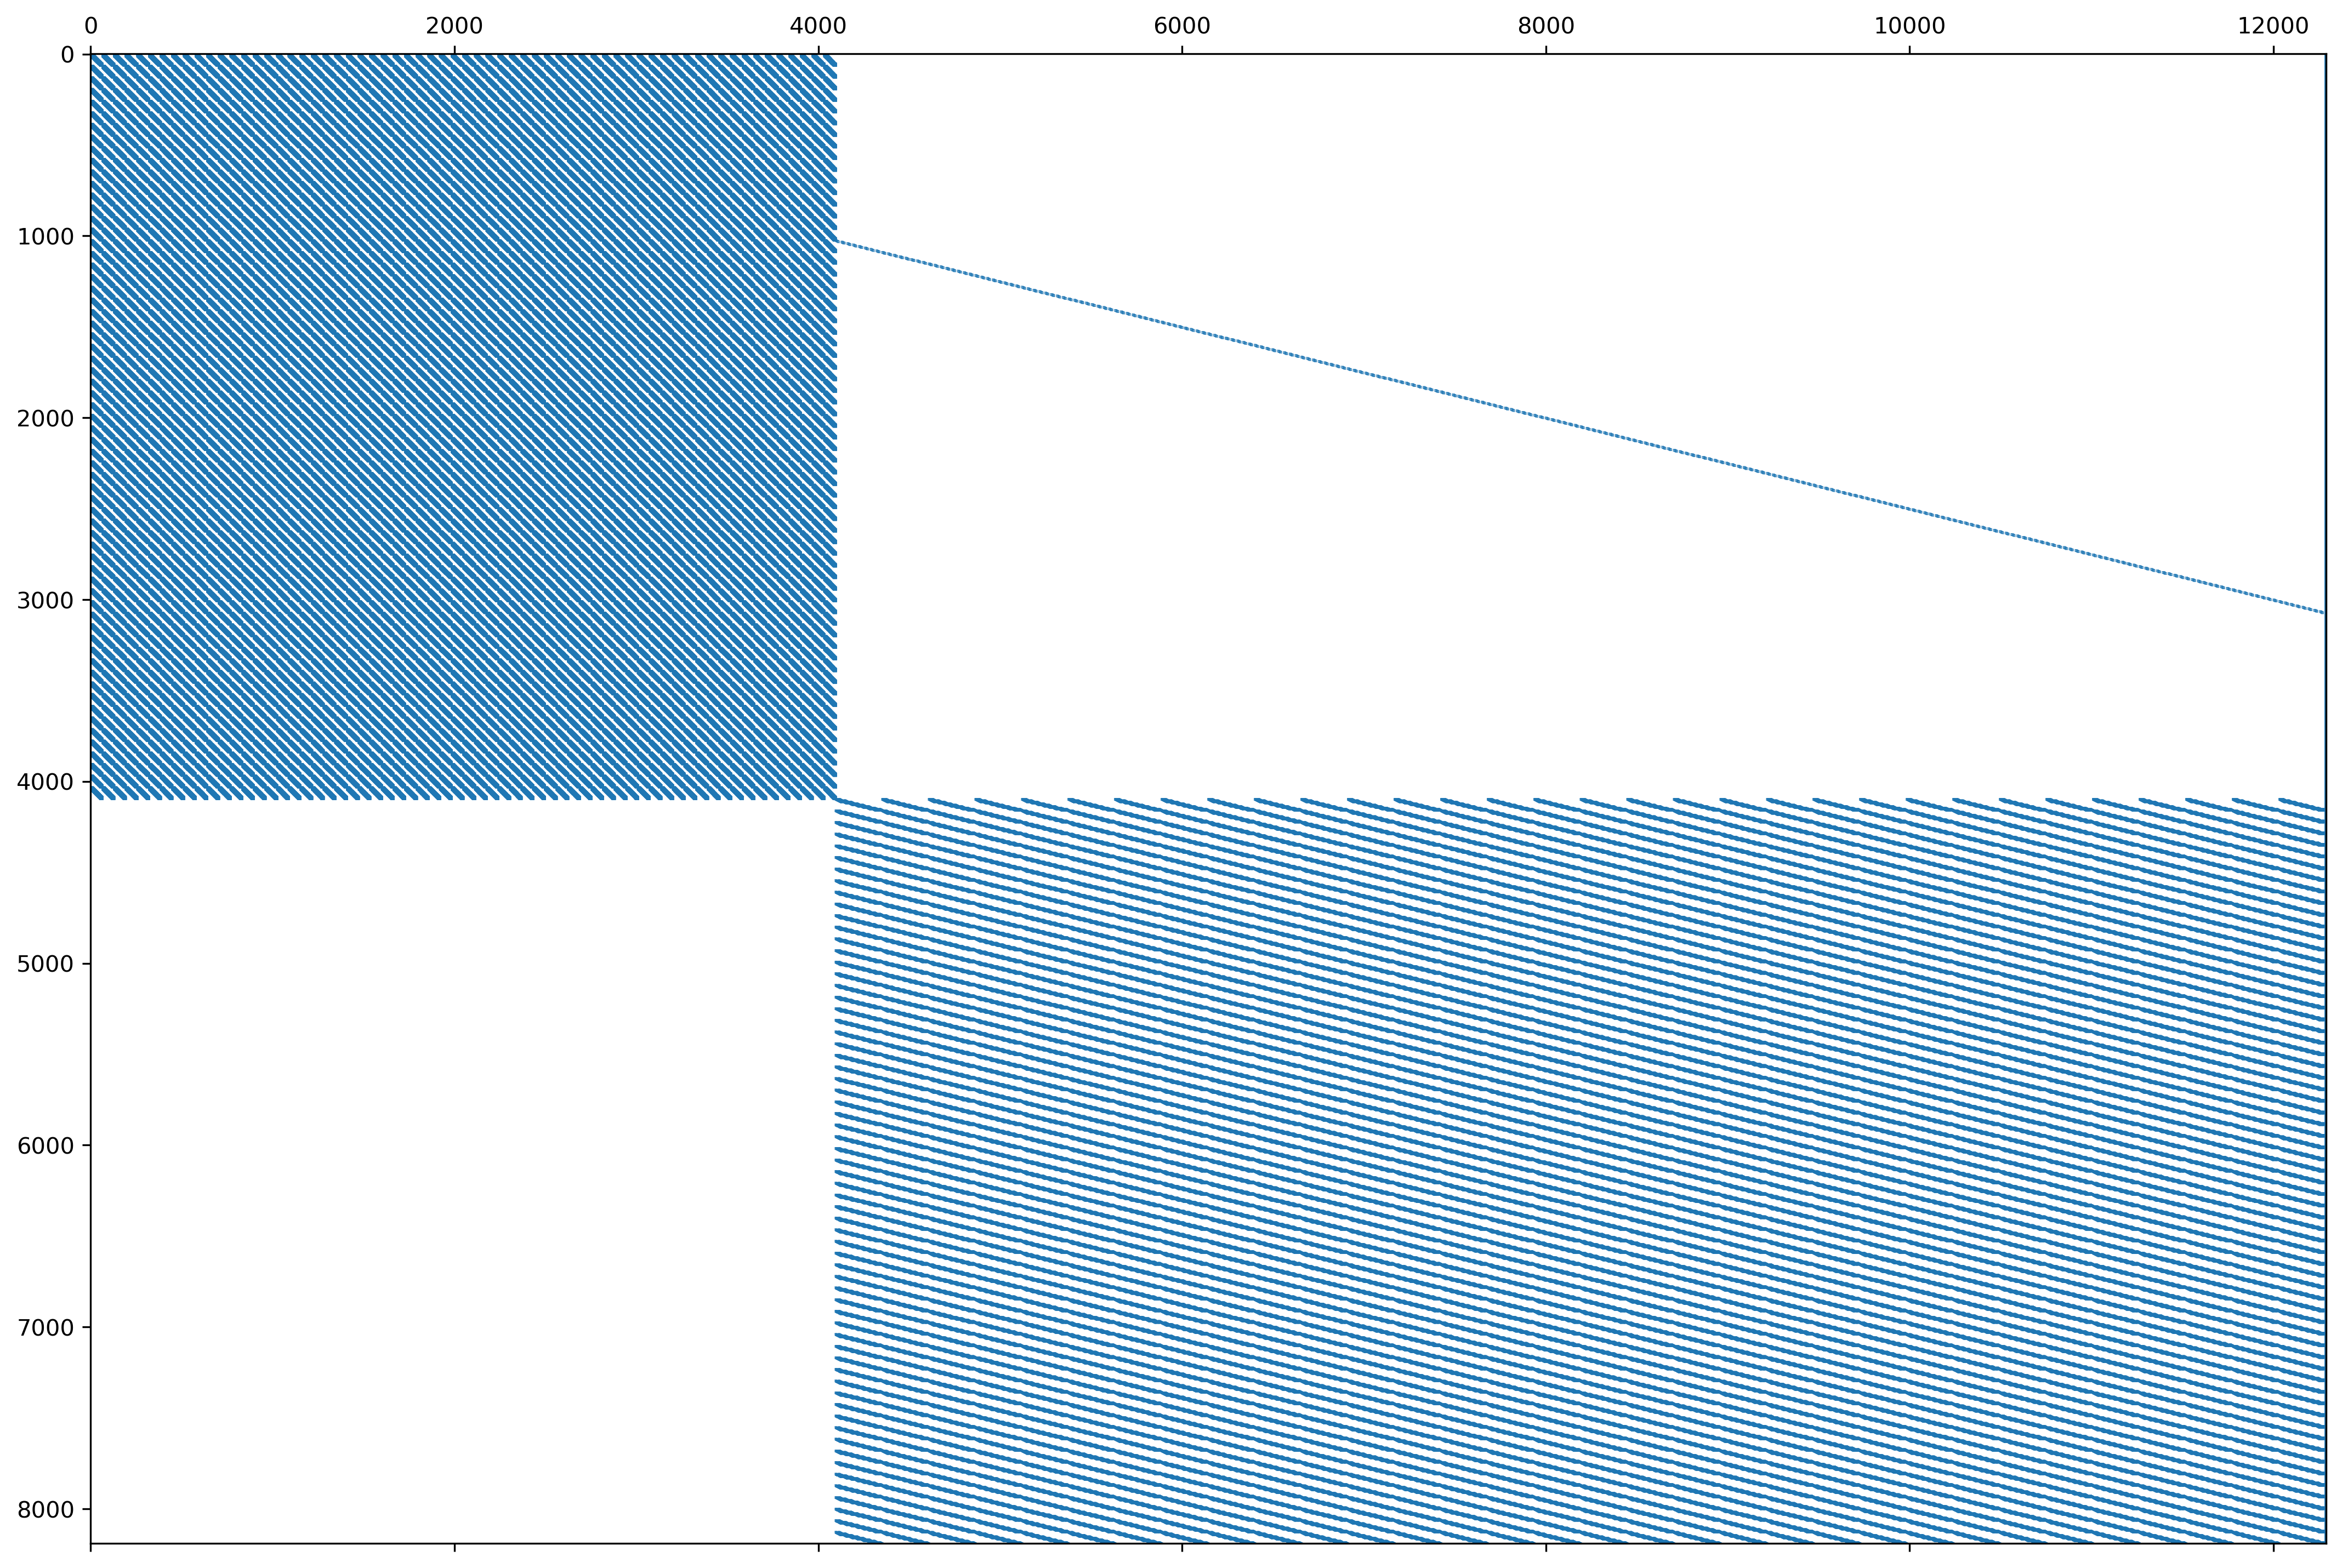

In [20]:
plt.figure(figsize=(18,12), dpi=300)
plt.spy(sp.bmat([[A2,b2]]), markersize=0.01)
plt.show()

In [21]:
# varification
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target
            input_var = input
            target_var = target

            # compute output
            output = model.implicit_forward(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % 2 == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))


    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))

    return top1.avg

criterion = torch.nn.CrossEntropyLoss()

In [ ]:
validate(val_loader, model, criterion)

norm diff for the batch: 0.32860222458839417
Test: [0/79]	Time 85.319 (85.319)	Loss 0.2042 (0.2042)	Prec@1 94.531 (94.531)
norm diff for the batch: 0.33881762623786926
norm diff for the batch: 0.3151529133319855
Test: [2/79]	Time 79.627 (81.403)	Loss 0.3014 (0.2534)	Prec@1 92.969 (93.229)
norm diff for the batch: 0.34324926137924194
norm diff for the batch: 0.33497968316078186
Test: [4/79]	Time 79.338 (80.377)	Loss 0.0834 (0.2126)	Prec@1 96.875 (94.219)
norm diff for the batch: 0.32901397347450256
norm diff for the batch: 0.33155739307403564
Test: [6/79]	Time 79.766 (80.089)	Loss 0.2815 (0.2341)	Prec@1 90.625 (93.638)
norm diff for the batch: 0.3514527678489685
